### Experiments Performance Evaluations ###

In [12]:
import os
import glob
import numpy as np
import pandas as pd
import glob
from matplotlib import pyplot as plt
import seaborn as sns

# Appearance of the Notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
np.set_printoptions(linewidth=110)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Import this module with autoreload
%load_ext autoreload
%autoreload 2
import llmt
from llmt.performance import Performance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Directories and data files
experiment_name = 'hcp_experiment_02'
data_root = os.path.join(os.environ.get('HOME'), 'home_data')
data_dir = os.path.join(data_root, 'hcp')
output_dir = os.path.join(data_dir, experiment_name)

# Collect the data for this experiment
parquet_file_list = sorted(glob.glob(os.path.join(output_dir, f'{experiment_name}_*.parquet')))
print(len(parquet_file_list))

df_list = []
for file in parquet_file_list:
    df_file = pd.read_parquet(file)
    df_file = df_file.\
        assign(run=int(os.path.basename(file).rsplit('_', maxsplit=2)[1]))
    df_list.append(df_file)
df = pd.concat(df_list, axis=0, ignore_index=True).\
        sort_values(by=['run', 'temperature', 'id'], ascending=True).\
        reset_index(drop=True)
print(df.shape)
display(df.head())

20
(3740, 13)


,id,name,description,mental_health,inpatient,outpatient,dset,pred_mh,pred_ip,pred_op,verified_op,temperature,run
0,100363-69,Chilton Hospital,Operator of inpatient hospital center. The com...,1.0,1.0,1.0,train,1,1,0,1,0.0,1
1,10127-62,Quest Diagnostics (NYS: DGX),Quest Diagnostics is a leading independent pro...,1.0,0.0,0.0,train,0,0,0,1,0.0,1
2,10195-21,IASIS Healthcare,Owner and operator of medium-sized acute care ...,1.0,1.0,1.0,train,0,1,1,1,0.0,1
3,10468-27,Behavioral Centers of America,Provider of psychiatric healthcare services. T...,1.0,1.0,1.0,train,1,1,1,1,0.0,1
4,107240-50,Alvarado Parkway Institute,Operator of a psychiatric health care facility...,1.0,1.0,1.0,train,1,1,1,1,0.0,1


In [9]:
# Mapping true variable and predictions
variable_dict = {'mental_health': 'pred_mh',
                 'inpatient': 'pred_ip',
                 'outpatient': 'pred_op'}

In [10]:
temperature_list = sorted(list(df['temperature'].unique()))
performance_df_list = []
for temperature in temperature_list:
    df_temperature = df.loc[df['temperature'] == temperature]
    run_list = sorted(df_temperature['run'].unique())
    for run in run_list:
        df_run = df.loc[(df['temperature'] == temperature) & (df['run'] == run)]
        for true_col, pred_col in variable_dict.items():
            performance_dict = Performance(data=df_run).\
                            binary_performance(true_col=true_col, pred_col=pred_col)
            performance_df = pd.DataFrame(performance_dict, index=[0])
            performance_df.insert(loc=0, column='X', value=true_col)
            performance_df.insert(loc=1, column='run', value=run)   
            performance_df.insert(loc=2, column='temperature', value=temperature)
            performance_df_list.append(performance_df)
performance_df = pd.concat(performance_df_list, axis=0, ignore_index=True)
display(performance_df.head())

,X,run,temperature,p,n,tp,tn,fp,fn,recall,precision,min_precision,specificity,f_score
0,mental_health,1,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
1,inpatient,1,0.0,69,113,68,103,10,1,0.9855,0.8718,0.3791,0.9115,0.9252
2,outpatient,1,0.0,94,42,77,31,11,17,0.8191,0.8750,0.6912,0.7381,0.8462
3,mental_health,2,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
4,inpatient,2,0.0,69,113,68,103,10,1,0.9855,0.8718,0.3791,0.9115,0.9252


### Make a bar graph for the repeated experiments at the two different temperatures ###

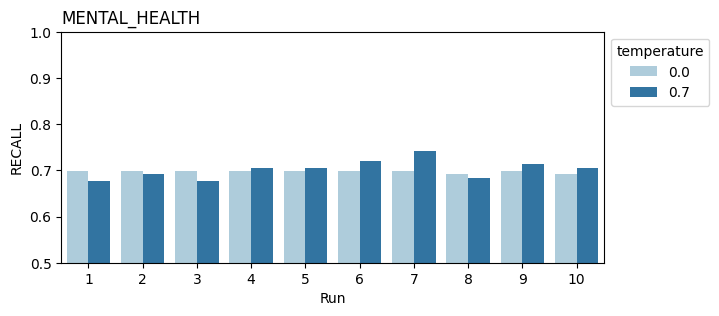

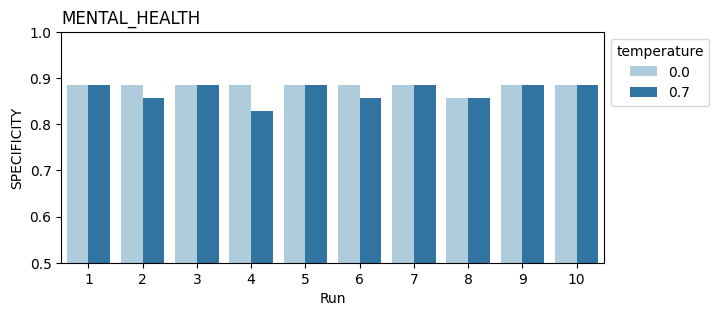

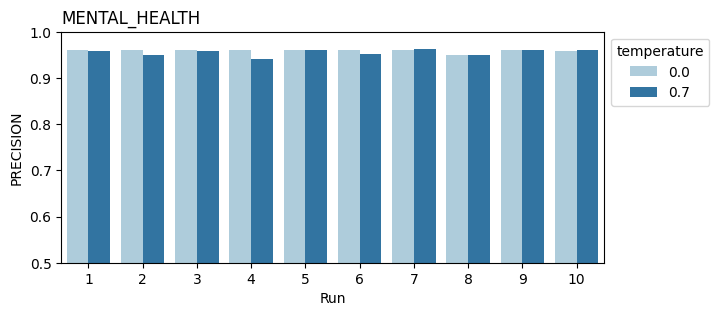

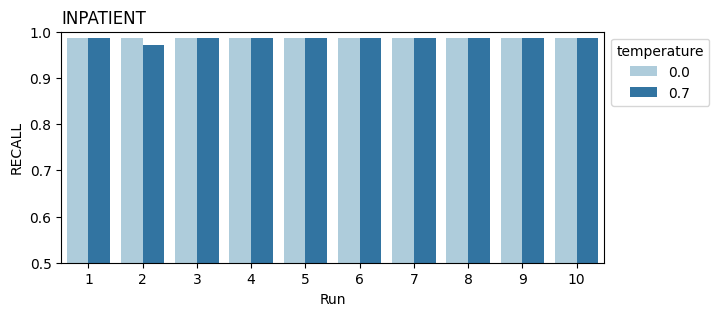

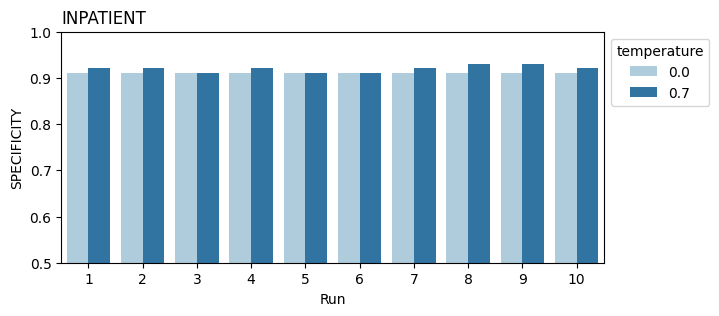

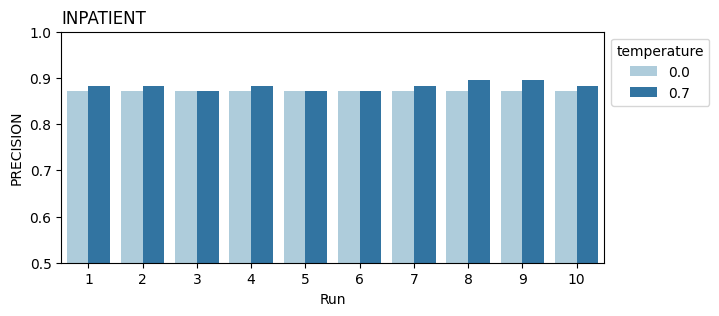

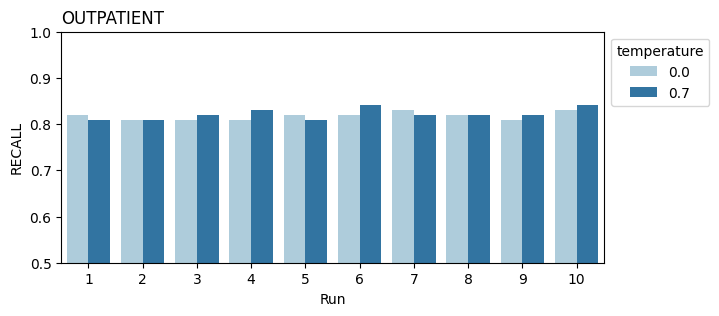

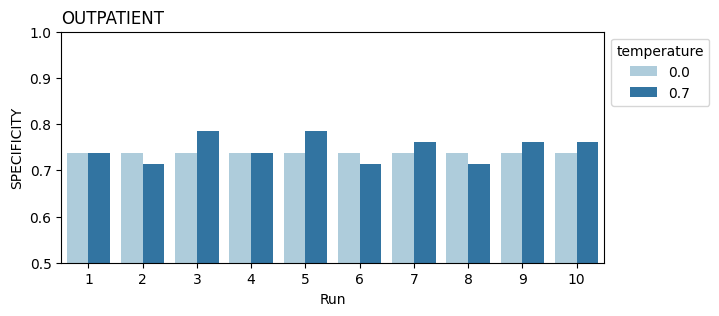

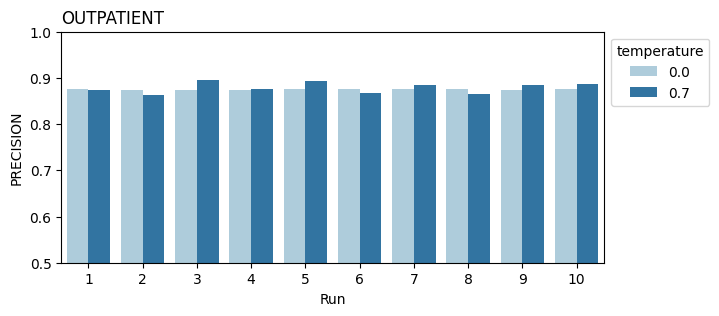

In [47]:
figsize = (7, 3)
for var in ['mental_health', 'inpatient', 'outpatient']:
    for metric in ['recall', 'specificity', 'precision']:
        performance_var = performance_df.loc[performance_df['X'] == var]
        figure_name = f'{experiment_name}_{var}_{metric}.png'
        figure_file = os.path.join(output_dir, figure_name)
        fig, ax = plt.subplots(figsize=figsize)
        sns.barplot(data=performance_var, x='run', y=metric, hue='temperature', palette='Paired', ax=ax)
        #ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title='Temperature')
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        ax.set(xlabel='Run', ylabel=metric.upper(),
               ylim = [0.5, 1.0], yticks=np.arange(0.5, 1.05, 0.1))
        ax.set_title(f'{var.upper()}', loc='left')
        plt.savefig(figure_file, bbox_inches='tight')
        plt.show()

In [14]:
display(performance_var)

,X,run,temperature,p,n,tp,tn,fp,fn,recall,precision,min_precision,specificity,f_score
0,mental_health,1,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
3,mental_health,2,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
6,mental_health,3,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
9,mental_health,4,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
12,mental_health,5,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
15,mental_health,6,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
18,mental_health,7,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
21,mental_health,8,0.0,136,35,94,30,5,42,0.6912,0.9495,0.7953,0.8571,0.8000
24,mental_health,9,0.0,136,35,95,31,4,41,0.6985,0.9596,0.7953,0.8857,0.8085
27,mental_health,10,0.0,136,35,94,31,4,42,0.6912,0.9592,0.7953,0.8857,0.8034


In [5]:
# Summary statistics
metric_list = ['tp', 'tn', 'fp', 'fn', 'recall', 'precision', 'specificity']
stat_df_list = []
for temperature in temperature_list:
    for x in variable_dict.keys():
        performance_x = performance_df.loc[
                        (performance_df['X'] == x) & 
                        (performance_df['temperature'] == temperature)]
        for metric in metric_list:
            metric_df = performance_x[metric].\
                        describe().\
                        to_frame().\
                        transpose().\
                        reset_index(drop=False).\
                        rename(columns={'index': 'metric'})
            metric_df.insert(loc=0, column='X', value=x)
            metric_df.insert(loc=1, column='temperature', value=temperature)
            stat_df_list.append(metric_df)
stat_df = pd.concat(stat_df_list, axis=0, ignore_index=True)
stat_df = stat_df.assign(experiment=2)
display(stat_df)

,X,temperature,metric,count,mean,std,min,25%,50%,75%,max,experiment
0,mental_health,0.0,tp,10.0,94.80000,0.421637,94.0000,95.000000,95.00000,95.000000,95.0000,2
1,mental_health,0.0,tn,10.0,30.90000,0.316228,30.0000,31.000000,31.00000,31.000000,31.0000,2
2,mental_health,0.0,fp,10.0,4.10000,0.316228,4.0000,4.000000,4.00000,4.000000,5.0000,2
3,mental_health,0.0,fn,10.0,41.20000,0.421637,41.0000,41.000000,41.00000,41.000000,42.0000,2
4,mental_health,0.0,recall,10.0,0.69704,0.003078,0.6912,0.698500,0.69850,0.698500,0.6985,2
5,mental_health,0.0,precision,10.0,0.95855,0.003182,0.9495,0.959600,0.95960,0.959600,0.9596,2
6,mental_health,0.0,specificity,10.0,0.88284,0.009044,0.8571,0.885700,0.88570,0.885700,0.8857,2
7,inpatient,0.0,tp,10.0,68.00000,0.000000,68.0000,68.000000,68.00000,68.000000,68.0000,2
8,inpatient,0.0,tn,10.0,103.00000,0.000000,103.0000,103.000000,103.00000,103.000000,103.0000,2
9,inpatient,0.0,fp,10.0,10.00000,0.000000,10.0000,10.000000,10.00000,10.000000,10.0000,2
